In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks

In [251]:
df = pd.read_excel("Discharge_670.xlsx", skiprows=3, usecols="E:AW", nrows=365)
df = df.drop(columns=1964)
df = df.dropna(how="all")
# display(df.head())

data = np.array([])
for column in df.columns[1:]:
    data = np.append(data, df[column].values)

df = pd.DataFrame(data, columns=["Discharge"])
date = pd.date_range(start="1965-01-01", periods=len(data), freq="D")
df["Date"] = date

df = df.set_index("Date")

display(df)


,Discharge
Date,
1965-01-01,61.793513
1965-01-02,61.793513
1965-01-03,61.793513
1965-01-04,61.793513
1965-01-05,60.690057
...,...
2006-08-31,66.682068
2006-09-01,65.496077
2006-09-02,64.819282


Number of exceedances: 18


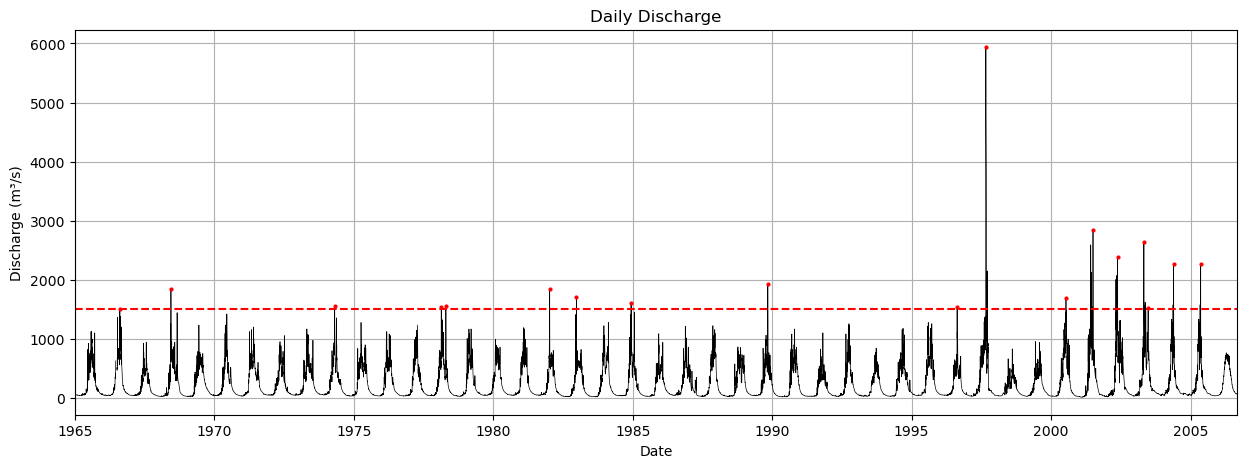

In [252]:
thresh = 1500   # threshold
period = 32    # period maxima
dl = 10000    # design life

exc_index, exceedances = find_peaks(data, height=thresh, distance=period)
exceedances = exceedances["peak_heights"]
print(f"Number of exceedances: {len(exceedances)}")

n = len(exceedances)
n_years = np.unique(date.year).size

avg_excess = n / n_years

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(date, data, color = 'k', linewidth=0.5)
ax.plot(date[exc_index], exceedances, 'ro', markersize=2)
ax.set_title("Daily Discharge")
ax.set_xlabel("Date")
ax.set_ylabel("Discharge (m³/s)")
ax.grid()
ax.hlines(thresh, date.min(), date.max(), colors="r", linestyles="dashed")
ax.set_xlim(date.min(), date.max())
plt.show()

exceedances = exceedances

In [253]:
x_ecdf = np.sort(exceedances)
y_ecdf = np.arange(1, n+1) / (n + 1)
x_pcdf = np.linspace(0, max(data), 100)

params_lognorm = stats.lognorm.fit(exceedances - thresh)
y_pcdf_lognorm = stats.lognorm.cdf(x_pcdf, *params_lognorm)
y_ppdf_lognorm = stats.lognorm.pdf(x_pcdf, *params_lognorm)

params_genextreme = stats.genextreme.fit(exceedances - thresh)
y_pcdf_genextreme = stats.genextreme.cdf(x_pcdf, *params_genextreme)
y_ppdf_genextreme = stats.genextreme.pdf(x_pcdf, *params_genextreme)

params_genpareto = stats.genpareto.fit(exceedances - thresh)
y_pcdf_genpareto = stats.genpareto.cdf(x_pcdf, *params_genpareto)
y_ppdf_genpareto = stats.genpareto.pdf(x_pcdf, *params_genpareto)

params_weibull = stats.exponweib.fit(exceedances - thresh, floc=0, f0=1)
y_pcdf_weibull = stats.exponweib.cdf(x_pcdf, *params_weibull)
y_ppdf_weibull = stats.exponweib.pdf(x_pcdf, *params_weibull)



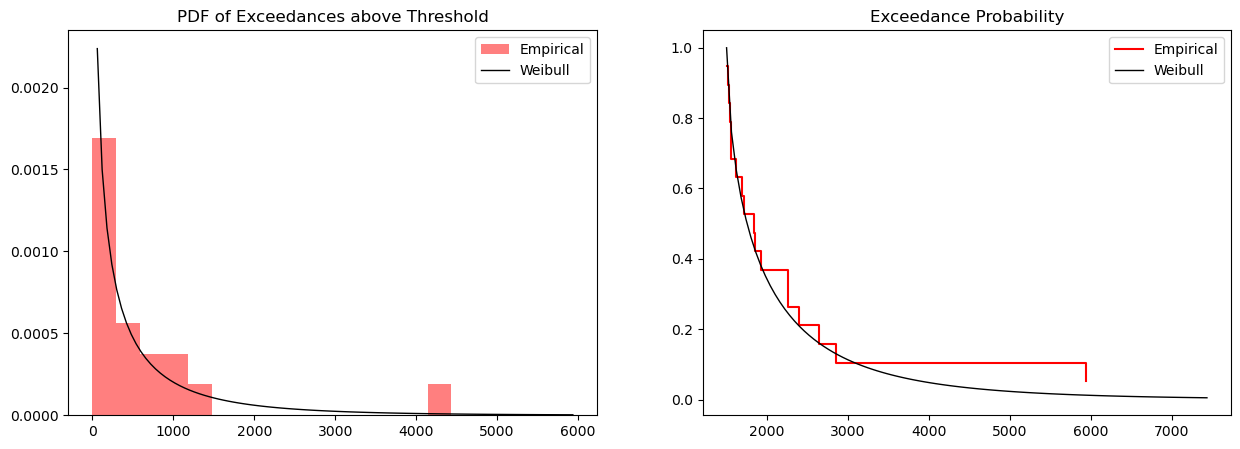

In [254]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(exceedances - thresh, bins=15, density=True, color='red', label='Empirical', alpha=0.5)
# ax[0].plot(x_pcdf, y_ppdf_genextreme, 'r-', lw=2, label='GenExtreme')
# ax[0].plot(x_pcdf, y_ppdf_genpareto, 'g-', lw=2, label='GenPareto')
# ax[0].plot(x_pcdf, y_ppdf_lognorm, 'b-', lw=2, label='LogNormal')
ax[0].plot(x_pcdf, y_ppdf_weibull, 'k-', lw=1, label='Weibull')
ax[0].set_title("PDF of Exceedances above Threshold")
ax[0].legend()

ax[1].step(x_ecdf, 1 - y_ecdf, 'r-', label='Empirical', where='post')
# ax[1].plot(x_pcdf + thresh, 1 - y_pcdf_genextreme, 'k-', lw=2, label='GenExtreme')
# ax[1].plot(x_pcdf + thresh, 1 - y_pcdf_genpareto, 'g-', lw=2, label='GenPareto')
# ax[1].plot(x_pcdf + thresh, 1 - y_pcdf_lognorm, 'b-', lw=2, label='LogNormal')
ax[1].plot(x_pcdf + thresh, 1 - y_pcdf_weibull, 'k-', lw=1, label='Weibull')
ax[1].set_title("Exceedance Probability")
ax[1].legend()

return level for T=10000 years: 3388701.6784574282 m³/s for GenExtreme
return level for T=10000 years: 135694.84715817327 m³/s for GenPareto
return level for T=10000 years: 9603.011387750259 m³/s for weibull
return level for T=10000 years: 1.8156869203275996e+16 m³/s for Log-Normal


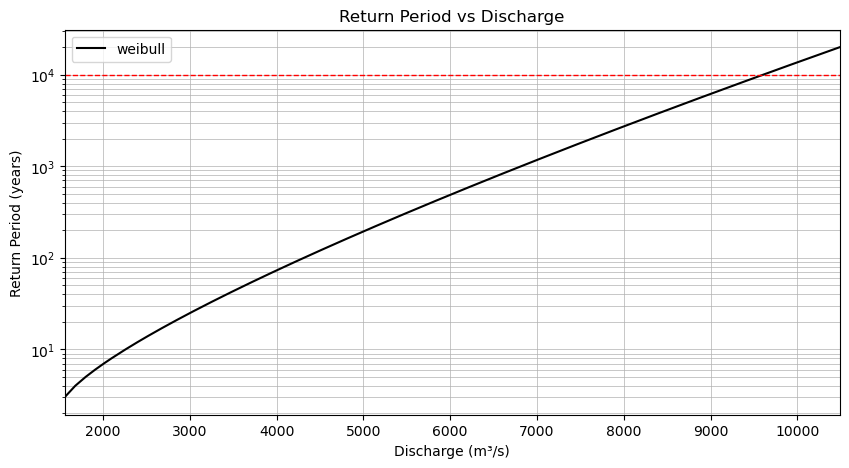

In [270]:
# return period
RT = np.arange(2, 20000, 1)

params = stats.genextreme.fit(exceedances - thresh)
DD_genextreme = stats.genextreme.ppf(1 - (1/(RT * avg_excess)), *params) + thresh

params = stats.genpareto.fit(exceedances - thresh)
DD_genpareto = stats.genpareto.ppf(1 - (1/(RT * avg_excess)), *params) + thresh

params = stats.exponweib.fit(exceedances - thresh)
DD_weib = stats.exponweib.ppf(1 - (1/(RT * avg_excess)), *params) + thresh

params = stats.lognorm.fit(exceedances - thresh)
DD_lognorm = stats.lognorm.ppf(1 - (1/(RT * avg_excess)), *params) + thresh

T = 10000

fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(DD_genextreme, RT, 'b-', label='GenExtreme')
# ax.plot(DD_genpareto, RT, 'g-', label='GenPareto')
ax.plot(DD_weib, RT, 'k-', label='weibull')
# ax.plot(DD_lognorm, RT, 'c-', label='Log-Normal')
ax.set_yscale('log')
ax.set_xlabel("Discharge (m³/s)")
ax.set_ylabel("Return Period (years)")
ax.set_title("Return Period vs Discharge")
ax.grid(which='both', linestyle='-', linewidth=0.5)
ax.hlines(T , DD_weib[1], DD_weib[-1], colors="r", linestyles="dashed", lw=1)
ax.set_xlim(DD_weib[1], DD_weib[-1])
ax.legend()

print(f"return level for T={T} years: {DD_genextreme[np.argmin(abs(RT - T))]} m³/s for GenExtreme")
print(f"return level for T={T} years: {DD_genpareto[np.argmin(abs(RT - T))]} m³/s for GenPareto")
print(f"return level for T={T} years: {DD_weib[np.argmin(abs(RT - T))]} m³/s for weibull")
print(f"return level for T={T} years: {DD_lognorm[np.argmin(abs(RT - T))]} m³/s for Log-Normal")
